Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
!pip install plotnine -q

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [3]:
# the bitly link wasn't working for me so I am hosting the file in my repository for this assignment

df_voles = pd.read_csv('https://raw.githubusercontent.com/UNC-DATA-730/unit-6-assignment-meganalvord/refs/heads/main/vole_trapping%20-%20vole_trapping.csv')

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [4]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

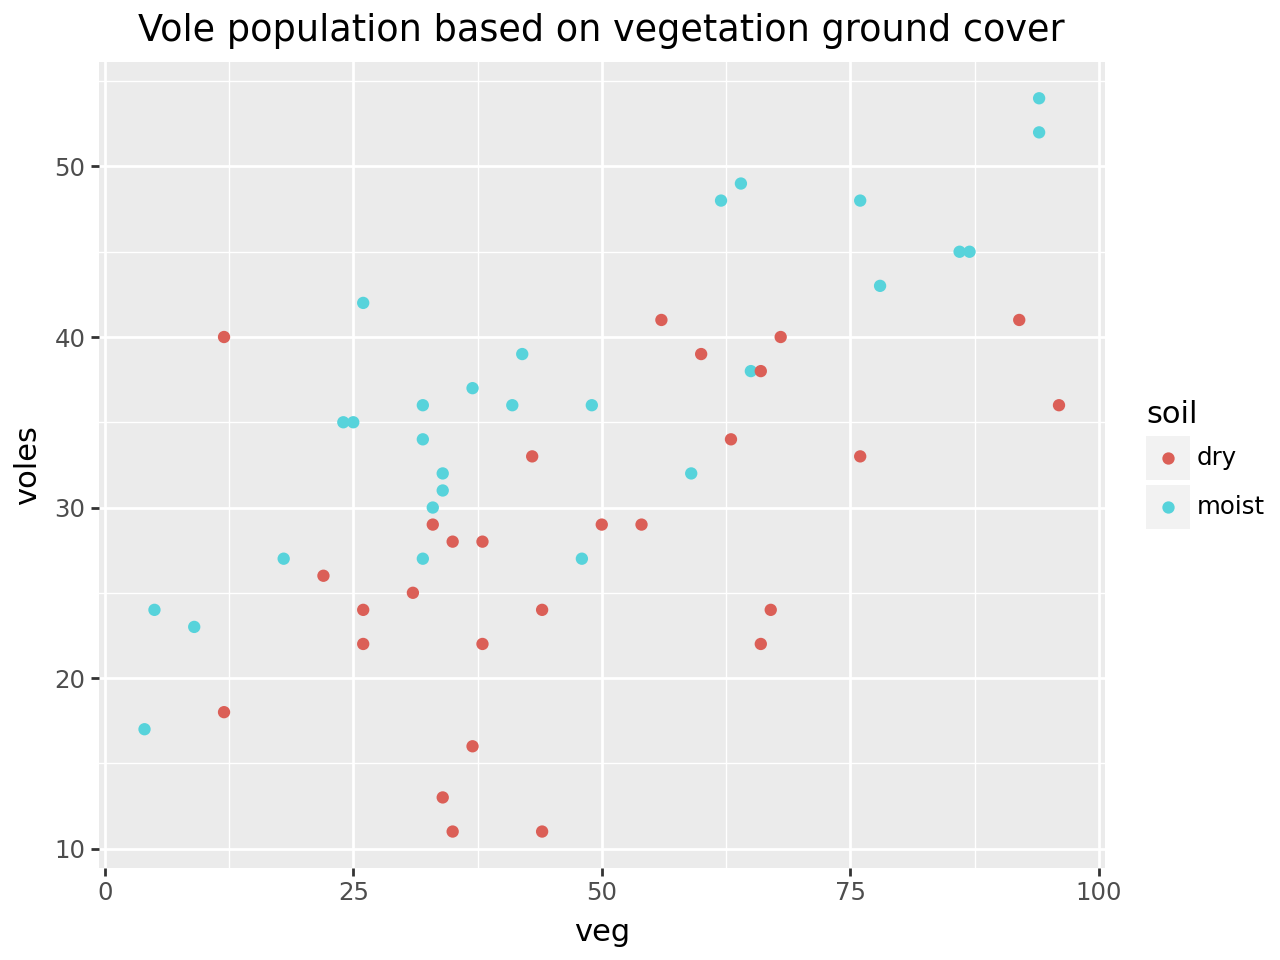

In [5]:
(
    ggplot(df_voles, aes(x = 'veg', y = 'voles', color = 'soil'))
    + geom_point()
    + ggtitle('Vole population based on vegetation ground cover')

)


## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [6]:
# step 1

ct = make_column_transformer(
    ('passthrough',['veg']), # no transformation here (already num value)
    (OneHotEncoder(drop='first'), ['soil']) # dummy encoded = turn categorical variable into num value
    # from reg table, dry was coded as 0 and moist was coded as 1
)

# https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html

In [7]:
# step 2

pl = make_pipeline(
    ct, 
    LinearRegression()
)

# doc: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html 
# Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, 
# conclude the sequence with a final predictor for predictive modeling.

In [8]:
# step 3
outcome = 'voles'

X, y = df_voles.loc[:, df_voles.columns != outcome], df_voles[outcome]

# df_voles.loc[:, df_voles.columns != outcome] = all rows, only columns that aren't "voles" 
# df_voles[outcome] = every value of vole counts


In [9]:
# step 4

pl.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['veg']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [10]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [11]:
reg_table = get_regression_table(pl)

In [12]:
reg_table

,term,estimate
0,passthrough__veg,0.259069
1,onehotencoder__soil_moist,9.100298
2,intercept,15.464026


In [13]:
# my attempt to get a graph with the lines on it

df_voles_wpred = df_voles.assign(pred_voles=lambda df_: pl.predict(df_)) 
# couldn't I just keep the same df and add a new column? why this method?

#df_voles_wpred.head()

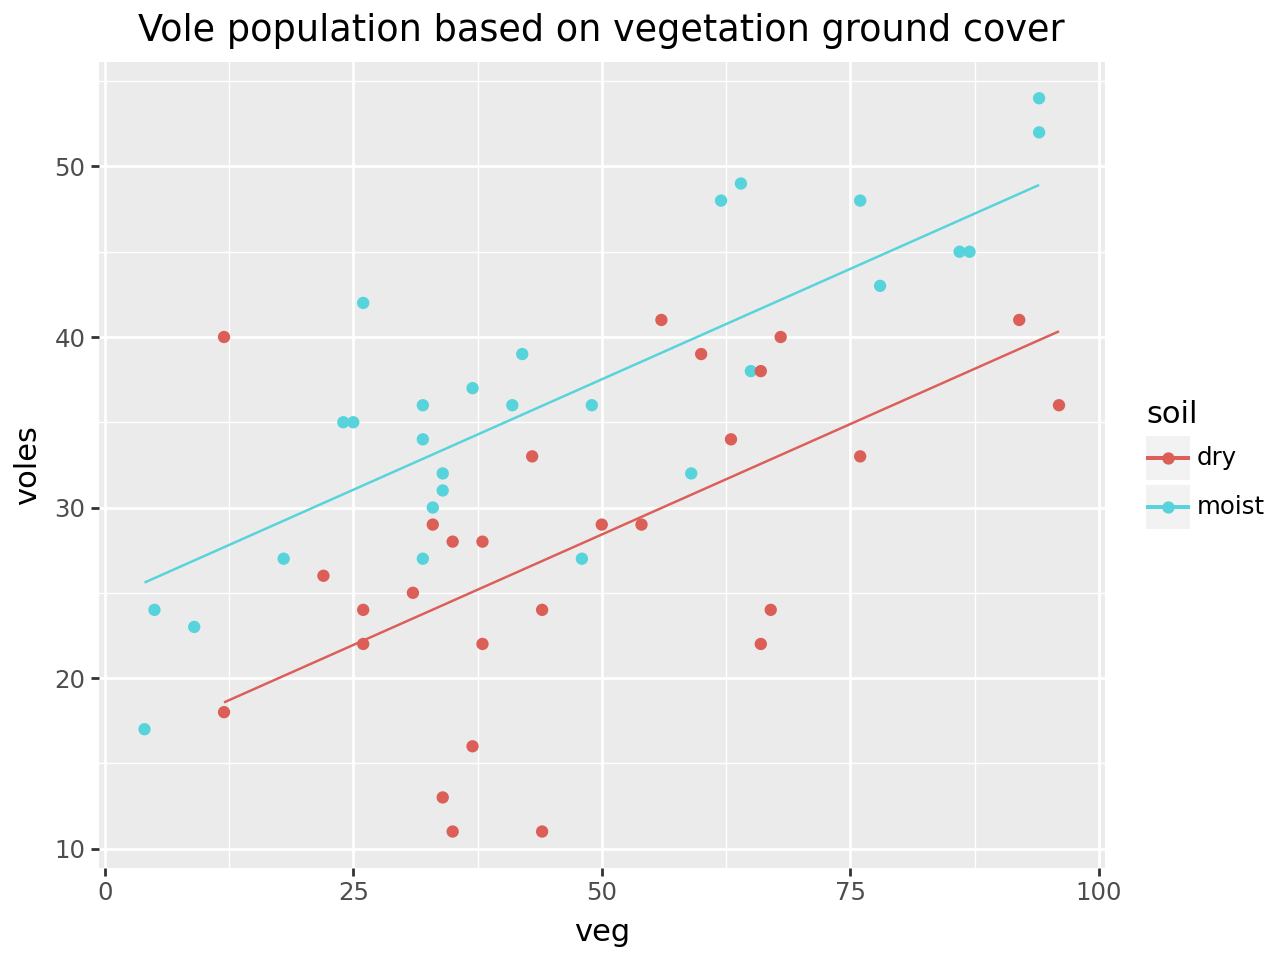

In [14]:
(
    ggplot(df_voles, aes(x = 'veg', y = 'voles', color = 'soil')) # original df
    + geom_point()
    + geom_line(df_voles_wpred, aes(y='pred_voles')) # new df
    + ggtitle('Vole population based on vegetation ground cover')
)

# hey, that kinda works!

❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

**As the amount of vegetation increases, the vole population also increases. We can see this from the positive relationship from the graph above and the positive estimated slope term of 0.259 vole count/veg % cover.**

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

**56% cover of vegetation is needed to maintain a site with dry soil and a population of 30 voles (see intersection below)**

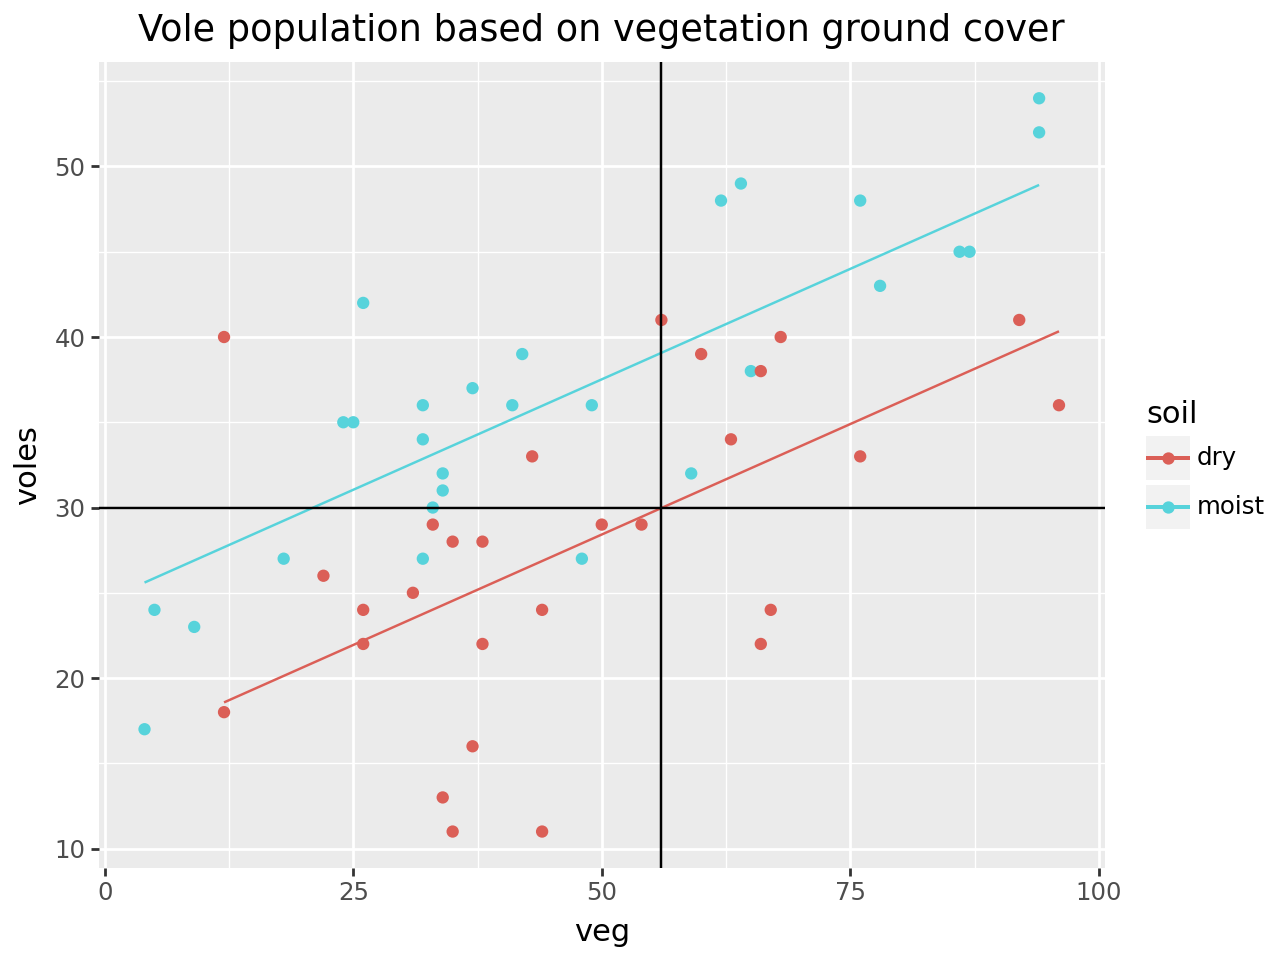

In [15]:
(
    ggplot(df_voles, aes(x = 'veg', y = 'voles', color = 'soil'))
    + geom_point()
    + geom_line(df_voles_wpred, aes(y='pred_voles'))
    + geom_hline(yintercept=30)
    + geom_vline(xintercept=56)
    + ggtitle('Vole population based on vegetation ground cover')
)

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with your pipeline.)

**Answer:**

In [16]:
prediction = pl.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

prediction

array([34.92708151])

**We would predict the vole population to be 34-35 voles on a site with moist soil and 40% vegetation coverage**

(We used two different methods to answer these last two questions, one with an eyeball estimation and one with code. Is this difference just because we are solving for a y variable in the last question and an x variable in the second to last? Could we use code to figure out the answer to an unknown x variable? Or just solving the equation given from the regression pipeline table? (which is what I would have my students do in class))